In [2]:
!pip install pandas

  Using cached pandas-2.3.2-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.2-cp311-cp311-win_amd64.whl (11.3 MB)
Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl (13.1 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install skimpy

  Using cached skimpy-0.0.18-py3-none-any.whl.metadata (34 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached rich-14.1.0-py3-none-any.whl.metadata (18 kB)
  Using cached typeguard-4.4.4-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyarrow-21.0.0-cp311-cp311-win_amd64.whl.metadata (3.4 kB)
  Using cached types_pytz-2025.2.0.20250809-py3-none-any.whl.metadata (1.7 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached skimpy-0.0.18-py3-none-any.whl (17 kB)
Using cached click-8.2.1-py3-none-any.whl (102 kB)
   ---------------------------------------- 0.0/157.8 kB ? eta -:--:--
   ------- -------------------------------- 30.7/157.8 kB 1.4 MB/s eta 0:00:01
   ----------------------- ---------------- 92.2/157.8 kB 1.1 MB/s eta 0:00:01
   ----------------------------- -------- 122.9/157.8 kB 901.1 kB/s eta 0:00:01
   ------------------------------------ - 153.6/15


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
! pip install seaborn matplotlib scikit-learn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/111.9 kB ? eta -:--:--
     --- ------------------------------------ 10.2/111.9 kB ? eta -:--:--
     ---------- -------------------------- 30.7/111.9 kB 325.1 kB/s eta 0:00:01
     ------------------------------ ------ 92.2/111.9 kB 744.7 kB/s eta 0:00:01
     -------------------------------- --- 102.4/111.9 kB 653.6 kB/s eta 0:00:01
     ------------------------------------ 111.9/111.9 kB 591.2 kB/s eta 0:00:00
  Using cached pillow-11.3.0-cp311-cp311-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached scipy-1.16.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.w


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [7]:
df = pd.read_csv(".data/311_Service_Requests_from_2010_to_Present_20250720.csv")
df.head()

C:\Users\aktkr\AppData\Local\Temp\ipykernel_20796\4173724161.py:1: DtypeWarning: Columns (17,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(".data/311_Service_Requests_from_2010_to_Present_20250720.csv")


,Created Date,Unique Key,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,07/18/2025 11:53:00 PM,65592123,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10029.0,NaN,NaN,NaN,NaN,2 AVENUE,EAST 105 STREET,INTERSECTION,MANHATTAN,NaN,NaN,Open,NaN,NaN,NaN,11 MANHATTAN,NaN,MANHATTAN,1000054.0,227082.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.789950,-73.942927,"(40.789949627890586, -73.94292662318264)"
1,07/18/2025 11:44:00 PM,65600030,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10024.0,230 WEST 79 STREET,WEST 79 STREET,AMSTERDAM AVE,BROADWAY,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Open,NaN,NaN,NaN,07 MANHATTAN,1.011700e+09,MANHATTAN,989947.0,224764.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.783600,-73.979428,"(40.783599632786924, -73.97942824609544)"
2,07/18/2025 11:32:00 PM,65600031,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10310.0,330 BARD AVENUE,BARD AVENUE,ST AUSTINS PL N,ST AUSTINS PL S,NaN,NaN,ADDRESS,STATEN ISLAND,NaN,NaN,Open,NaN,NaN,NaN,01 STATEN ISLAND,5.001400e+09,STATEN ISLAND,954601.0,171027.0,PHONE,Unspecified,STATEN ISLAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.636057,-74.106825,"(40.63605656815797, -74.1068252625984)"
3,07/18/2025 11:29:00 PM,65600095,NaN,DEP,Department of Environmental Protection,Noise,"Noise: Boat(Engine,Music,Etc) (NR10)",NaN,11357.0,168-11 12 AVENUE,12 AVENUE,BEND,DEAD END,NaN,NaN,ADDRESS,WHITESTONE,NaN,NaN,Open,NaN,NaN,NaN,07 QUEENS,4.046020e+09,QUEENS,1040801.0,227726.0,ONLINE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.791550,-73.795771,"(40.79155042461777, -73.79577089126887)"
4,07/18/2025 11:26:00 PM,65592192,NaN,DEP,Department of Environmental Protection,Noise,"Noise: Boat(Engine,Music,Etc) (NR10)",NaN,11357.0,168-11 12 AVENUE,12 AVENUE,BEND,DEAD END,NaN,NaN,ADDRESS,WHITESTONE,NaN,NaN,Open,NaN,NaN,NaN,07 QUEENS,4.046020e+09,QUEENS,1040801.0,227726.0,ONLINE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.791550,-73.795771,"(40.79155042461777, -73.79577089126887)"


In [8]:
from skimpy import skim

skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 793783 │ │ string      │ 27    │                                                          │
│ │ Number of columns │ 41     │ │ float64     │ 13    │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                    All null                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓  │
│ ┃ column                                                          ┃ NA                     ┃ NA %            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩  │
│ │ Vehicle Type                                                    │                 793783 │             100 │  │
│ │ Taxi Company Borough                                            │                 793783 │             100 │  │
│ │ Taxi Pick Up Location                                           │                 793783 │             100 │  │
│ │ Bridge Highway Name                                             │                 793783 │             100 │  │
│ │ Bridge Highway Direction                                        │                 793783 │             100 │  │
│ │ Road Ramp                                                       │                 793783 │             100 │  │
│ │ Bridge Highway Segment                                          │                 793783 │             100 │  │
│ └─────────────────────────────────────────────────────────────────┴────────────────────────┴─────────────────┘  │
│                                                     number                                                      │
│ ┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column  ┃ NA     ┃ NA %    ┃ mean    ┃ sd      ┃ p0      ┃ p25     ┃ p50     ┃ p75      ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ Unique  │      0 │       0 │ 4004000 │ 1363000 │ 1564000 │ 2899000 │ 3824000 │ 52130000 │ 6560000 │ ▅▇▇▅▅▆ │  │
│ │ Key     │        │         │       0 │       0 │       0 │       0 │       0 │          │       0 │        │  │
│ │ Inciden │   6852 │ 0.86320 │   10630 │   596.4 │       0 │   10020 │   10460 │    11220 │   12340 │     ▆▇ │  │
│ │ t Zip   │        │ 8206776 │         │         │         │         │         │          │         │        │  │
│ │         │        │    9151 │         │         │         │         │         │          │         │        │  │
│ │ BBL     │ 188878 │ 23.7946 │ 2394000 │ 1308000 │       0 │ 1012000 │ 3002000 │ 30740000 │ 5270000 │  ▇▁▅▃▁ │  │
│ │         │        │ 6428482 │     000 │     000 │         │     000 │     000 │       00 │     000 │        │  │
│ │         │        │    3433 │         │         │         │         │         │          │         │        │  │
│ │ X       │  11384 │ 1.43414 │  998500 │   19700 │  913300 │  987600 │  995200 │  1006000 │ 1067000 │   ▆▇▂▁ │  │
│ │ Coordin │        │ 5100109 │         │         │    

### Handling Missing Values

  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


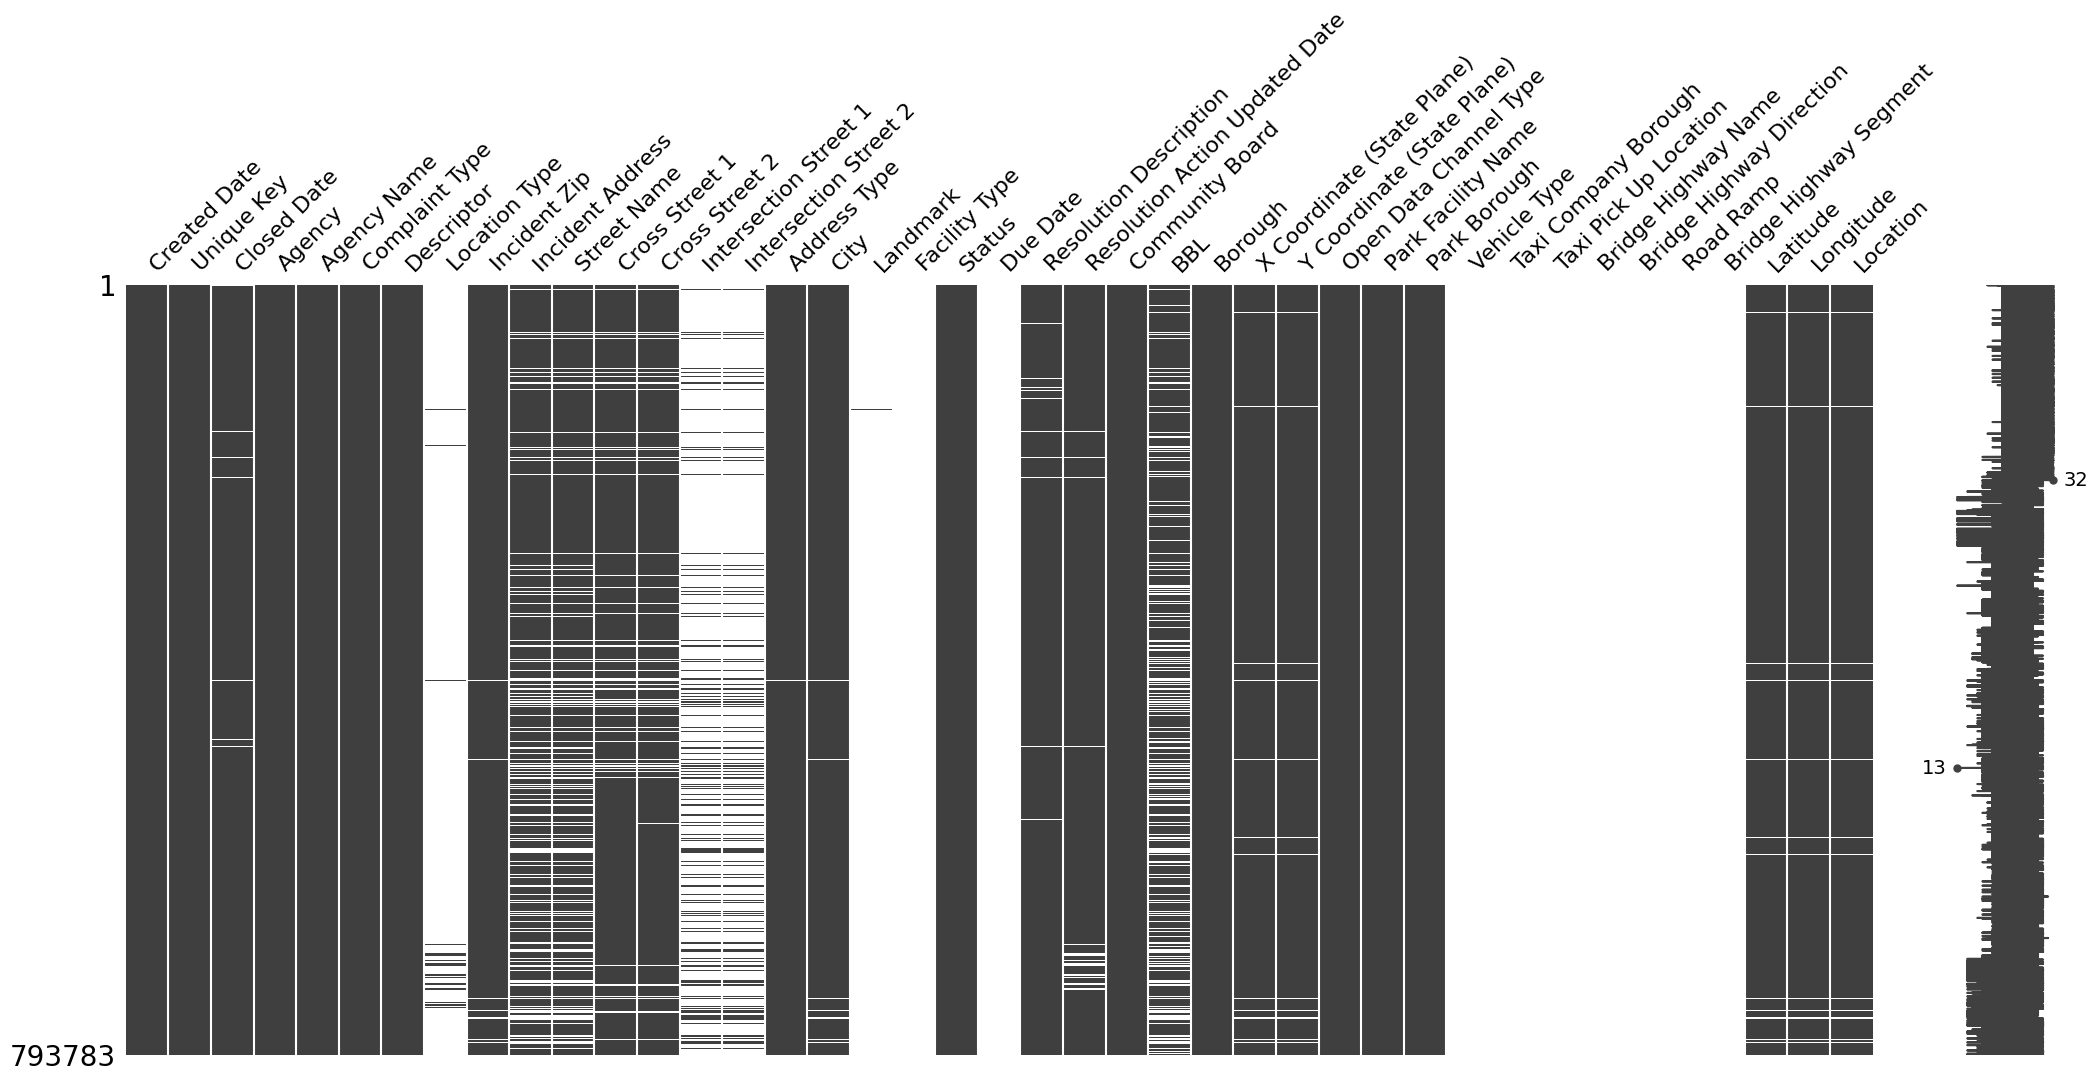

In [9]:
!pip install missingno
import missingno as msno

msno.matrix(df)
plt.show()

In [10]:
missing_pct = df.isnull().mean().round(4).sort_values(ascending=False) * 100
cols_over_50 = missing_pct[missing_pct >= 50].index
df[cols_over_50].columns

Index(['Due Date', 'Vehicle Type', 'Taxi Company Borough',
       'Bridge Highway Name', 'Bridge Highway Segment', 'Road Ramp',
       'Bridge Highway Direction', 'Taxi Pick Up Location', 'Facility Type',
       'Landmark', 'Location Type', 'Intersection Street 1',
       'Intersection Street 2'],
      dtype='object')

In [11]:
df.drop(columns=cols_over_50, inplace=True)
df.shape

(793783, 28)